<a href="https://colab.research.google.com/github/Tomershigani/ALGO/blob/master/FINAL_PROJECT_PART_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install findspark
!pip install pyspark
!pip install importlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 43.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9c5c5d3ea7209e2fdda210689b5ee594f97bd03cd10b2ca4bda1e40baa66ebc4
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for importlib: filename=importlib-1.0.4-py3-none-any.whl size=5875 sha256=5d0e7a985e2c0ffda52888394cb90d920206f6de41b9db2089eef207eccc2535
  Stored in directory: /root/.cache/pip/wheels/86/e4/cb/62b0e9efd7da1e984baec0c0ded0b727a7ed25e1904ed51fca
Successfully built importlib


In [ ]:
%%file part1.py

def get_all_df():
  import findspark
  findspark.init()
  from pyspark.sql import SparkSession

  def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

  spark, sc = init_spark('demo')

  import re
  from pyspark.sql import functions as f
  from pyspark.sql import types as T
  import pandas as pd
  import matplotlib.pyplot as plt
  from pyspark.sql.functions import col,when
  import numpy as np 

  # load the data as you did before, just now change the delimiter to get evrey thing together
  credits =  spark.read.format("csv")\
    .option("delimiter", "\t")\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load("credits.csv")

  prog = re.compile('\\[(.*?)\\]')
  second_match = f.udf(lambda x: prog.findall(x)[1])
  id_extract = f.udf(lambda x: x.split(",")[-1])

  credits = credits\
    .withColumn("cast", f.regexp_extract(f.col("cast,crew,id"), '\\[(.*?)\\]', 0))\
    .withColumn("id", id_extract("cast,crew,id"))\
    .withColumn("crew", f.concat(f.lit("["),second_match("cast,crew,id"), f.lit("]")))\
    .select("cast", "crew", "id")

  #explodes the dataframe

  #from pyspark.sql import types as T
  schema_cast = T.ArrayType(T.StructType([T.StructField('order', T.IntegerType()), T.StructField('id', T.IntegerType()),T.StructField('name', T.StringType())
  , T.StructField('gender', T.IntegerType())  ]))
  schema_crew = T.ArrayType(T.StructType([ T.StructField('id', T.IntegerType()),T.StructField('name', T.StringType()),T.StructField('job', T.StringType())
          , T.StructField('gender', T.IntegerType()) ]))

  df = credits.withColumn("cast", f.explode(f.from_json(credits['cast'], schema=schema_cast)))\
                .withColumn("crew", f.explode(f.from_json(credits['crew'], schema=schema_crew)))



  df = df.filter(df.crew.job == "Director")

  # unexplodes the dataframe

  credits = df.groupBy("id").agg(f.array_sort(f.collect_set("cast"))\
  .alias("cast"),f.collect_set("crew").alias("crew"))
  
  # making full movies  #############################################################################

  from pyspark.sql import functions as F
  from pyspark.sql.functions import col, concat_ws

  #loading movies
  dataPath = "movies.csv"
  movies = spark.read.format("csv")\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load(dataPath)

  #removing unnecessary data from schemas
  genres_schema = T.ArrayType(T.StructType([T.StructField('name', T.StringType())]))
  movies = movies.withColumn("genres", f.explode(f.from_json(movies['genres'], schema=genres_schema)))

  production_companies_schema = T.ArrayType(T.StructType([T.StructField('name', T.StringType())]))
  movies = movies.withColumn("production_companies", f.explode(f.from_json(movies['production_companies'], schema=production_companies_schema)))

  production_countries_schema = T.ArrayType(T.StructType([T.StructField('name', T.StringType())]))
  movies = movies.withColumn("production_countries", f.explode(f.from_json(movies['production_countries'], schema=production_countries_schema)))

  movies = movies.withColumn('cities',  f.translate(f.col("cities"), "[]'", "")) 
  movies = movies.withColumn('cities',f.explode(f.split('cities',', ')).alias("cities"))

  spoken_languages_schema = T.ArrayType(T.StructType([T.StructField('name', T.StringType())]))
  movies = movies.withColumn("spoken_languages", f.explode(f.from_json(movies['spoken_languages'], schema=spoken_languages_schema)))

  #adding schema
  movies = movies.withColumn('Overview_length', f.length("overview"))

  #removing unnecessary schemas
  movies = movies.drop("overview")
  movies = movies.drop("tagline")


  movies = movies.withColumn("release_date",concat_ws("/",col("release_date")))
  movies=   movies.withColumn('release_date',f.to_date('release_date', "dd/MM/yyyy"))

  movies = movies.withColumn('release_date',f.year(movies.release_date))

  for colu in ["spoken_languages","production_companies","genres","production_countries"]:
      movies = movies.withColumn(colu,col(colu)["name"])

  from pyspark.sql.functions import when

  movies = movies.withColumn("spoken_languages", when((movies.spoken_languages != "English") & (movies.spoken_languages  != "עִבְרִית"),"Other")\
  .when(movies.spoken_languages  == "עִבְרִית","Hebrew")\
  .otherwise(movies.spoken_languages))

  # unexplodes the movies dataframe
  movies = movies.groupBy("movie_id").agg(f.array_sort(f.collect_set("genres"))\
  .alias("genres"),f.collect_set("production_companies").alias("production_companies"),
  f.collect_set("production_countries").alias("production_countries"),f.collect_set("release_date").alias("release_date")
  ,f.collect_set("revenue").alias("revenue"),f.collect_set("spoken_languages").alias("spoken_languages")
  ,f.collect_set("title").alias("title"),f.collect_set("cities").alias("cities")
  ,f.collect_set("Overview_length").alias("Overview_length"))


  # join between movies and credits
  full_movies = movies.join(credits,movies.movie_id ==  credits.id,"outer")
  full_movies = full_movies.drop("id") 

  # making full tickets  #############################################################################


  #loading tickets
  dataPath = "tickets.csv"
  tickets = spark.read.format("csv")\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load(dataPath)


  #loading users
  dataPath = "users.csv"
  users = spark.read.format("csv")\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load(dataPath)


  # join between tickets and users
  users = users.withColumnRenamed("user_id","user_id1")
  full_tickets = tickets.join(users,tickets.user_id ==  users.user_id1,"outer")
  full_tickets = full_tickets.drop("user_id1") 

  # making queries  #############################################################################


  #loading queries
  from pyspark.sql import functions as f

  dataPath = "queries.csv"
  queries = spark.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)
  queries = queries.withColumn("from_realese_date",f.regexp_replace(col("from_realese_date"),"[a-zA-Z]","")).withColumn("from_realese_date",when(f.length(f.trim(col("from_realese_date")))==0,f.lit(0)).otherwise(col("from_realese_date")))


  queries.filter(queries.from_realese_date=="")


  # chaging empty lists to null 
  queries=queries.withColumn("actors", \
        when(col("actors")=='[]' ,None) \
          .otherwise(col("actors"))) 

  queries=queries.withColumn("from_realese_date", \
        when(col("from_realese_date")=='[]' ,None) \
          .otherwise(col("from_realese_date"))) 
  queries=queries.withColumn("director", \
        when(col("director")=='[]' ,None) \
          .otherwise(col("director"))) 

  queries=queries.withColumn("country", \
        when(col("country")=='[]' ,None) \
          .otherwise(col("country"))) 
  
  full_movies = full_movies.drop("revenue")

  return full_movies, full_tickets, queries


Overwriting part1.py


In [ ]:
from importlib import reload
import part1 

reload(part1)
full_movies, full_tickets, queries = part1.get_all_df()


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

spark, sc = init_spark('demo')

PART 2


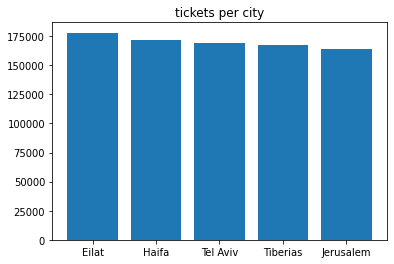

Tickets bought in Eilat
+---------+----------------------+
|city     |sum(number_of_tickets)|
+---------+----------------------+
|Eilat    |29012                 |
|Haifa    |27725                 |
|Tel Aviv |27205                 |
|Tiberias |27174                 |
|Jerusalem|26927                 |
|null     |null                  |
+---------+----------------------+

Tickets bought in Haifa
+---------+----------------------+
|city     |sum(number_of_tickets)|
+---------+----------------------+
|Eilat    |47949                 |
|Haifa    |45815                 |
|Tel Aviv |45384                 |
|Tiberias |45223                 |
|Jerusalem|44004                 |
|null     |null                  |
+---------+----------------------+

Tickets bought in Tel aviv
+---------+----------------------+
|city     |sum(number_of_tickets)|
+---------+----------------------+
|Eilat    |29062                 |
|Haifa    |28559                 |
|Tel Aviv |27819                 |
|Tiberias |27

In [ ]:
#First insight
import re
from pyspark.sql import functions as f
from pyspark.sql import types as T
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,when
import numpy as np 


all_ticikets  = full_tickets.groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
all = all_ticikets.toPandas()
all = all.dropna()
plt.bar(all['city'], all['sum(number_of_tickets)'] )
plt.title('tickets per city')
plt.show()

print("Tickets bought in Eilat")
outter_movies_Eilat = full_tickets.filter(full_tickets.user_location == "Eilat").groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
outter_movies_Eilat.show(truncate=False)
print("Tickets bought in Haifa")
outter_movies_Haifa = full_tickets.filter(full_tickets.user_location == "Haifa").groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
outter_movies_Haifa.show(truncate=False)
print("Tickets bought in Tel aviv")
outter_movies_TelAviv = full_tickets.filter(full_tickets.user_location == "Tel Aviv").groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
outter_movies_TelAviv.show(truncate=False)
print("Tickets bought in Kibuts Gesher")
outter_movies_Tiberias  = full_tickets.filter(full_tickets.user_location == "Kibuts Gesher").groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
outter_movies_Tiberias.show(truncate=False)
print("Tickets bought in Jerusalem")
outter_movies_Jerusalem  = full_tickets.filter(full_tickets.user_location == "Jerusalem").groupBy("city").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
outter_movies_Jerusalem.show(truncate=False)


תובנה מספר 1: מהגרף ניתן להבחין כי "האתר" באילת הינו האתר אשר מכר את הכמות הכרטיסים הגדולה ביותר.
ולכן נחקור את המגמה - עבור כל מיקום נבדוק מהו "האתר" המוזמן ביותר.
ואכן מהטבלאות ניתן לראות כי בכל מיקום העיר אילת הינה האתר המוזמן ביותר    


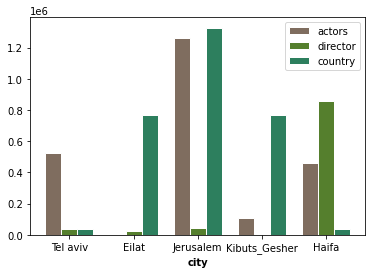

In [ ]:
#Second insight


TelAviv_clients = full_tickets.filter(full_tickets.user_location=="Tel Aviv")

Tlv_query = TelAviv_clients.join(queries,TelAviv_clients.user_id==queries.user_id,"inner")

tlv_actors = Tlv_query.filter(col("actors").isNotNull()).count()
tlv_director = Tlv_query.filter(col("director").isNotNull()).count()
tlv_country =Tlv_query.filter(col("country").isNotNull()).count()

Eilat_clients = full_tickets.filter(full_tickets.user_location=="Eilat")
Eilat_query = Eilat_clients.join(queries,Eilat_clients.user_id==queries.user_id,"inner")
Eilat_actors = Eilat_query.filter(col("actors").isNotNull()).count()
Eilat_director = Eilat_query.filter(col("director").isNotNull()).count()
Eilat_country =Eilat_query.filter(col("country").isNotNull()).count()

Jerusalem_clients = full_tickets.filter(full_tickets.user_location=="Jerusalem")
Jerusalem_query = Jerusalem_clients.join(queries,Jerusalem_clients.user_id==queries.user_id,"inner")
Jerusalem_actors = Jerusalem_query.filter(col("actors").isNotNull()).count()
Jerusalem_director = Jerusalem_query.filter(col("director").isNotNull()).count()
Jerusalem_country =Jerusalem_query.filter(col("country").isNotNull()).count()

Kibuts_Gesher_clients = full_tickets.filter(full_tickets.user_location=="Kibuts Gesher")
Kibuts_Gesher_query = Kibuts_Gesher_clients.join(queries,Kibuts_Gesher_clients.user_id==queries.user_id,"inner")
Kibuts_Gesher_actors = Kibuts_Gesher_query.filter(col("actors").isNotNull()).count()
Kibuts_Gesher_director = Kibuts_Gesher_query.filter(col("director").isNotNull()).count()
Kibuts_Gesher_country =Eilat_query.filter(col("country").isNotNull()).count()

Haifa_clients = full_tickets.filter(full_tickets.user_location=="Haifa")
Haifa_query = Haifa_clients.join(queries,Haifa_clients.user_id==queries.user_id,"inner")
Haifa_actors = Haifa_query.filter(col("actors").isNotNull()).count()
Haifa_director = Haifa_query.filter(col("director").isNotNull()).count()
Haifa_country =Haifa_query.filter(col("country").isNotNull()).count()


# set width of bars
barWidth = 0.25
 
# set heights of bars
cities = ['Tel aviv','Eilat','Jerusalem','Kibuts_Gesher','Haifa' ]
yactors = [tlv_actors,Eilat_actors,Jerusalem_actors,Kibuts_Gesher_actors,Haifa_actors]
ydirector = [tlv_director,Eilat_director,Jerusalem_director,Kibuts_Gesher_director,Haifa_director]
ycountry = [tlv_country,Eilat_country,Jerusalem_country,Kibuts_Gesher_country,Haifa_country]


# Set position of bar on X axis
r1 = np.arange(len(yactors))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, yactors, color='#7f6d5f', width=barWidth, edgecolor='white', label='actors')
plt.bar(r2, ydirector, color='#557f2d', width=barWidth, edgecolor='white', label='director')
plt.bar(r3, ycountry, color='#2d7f5e', width=barWidth, edgecolor='white', label='country')
 
# Add xticks on the middle of the group bars
plt.xlabel('city', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(yactors))], cities)
 
# Create legend & Show graphic
plt.legend()
plt.show()



תובנה מספר 2: מהגרף ניתן לראות את התפלגות השאילתות בכל אחת מהערים ביחס למפתח חיפוש מסוים
כאשר לקוחות אשר גרים בירושלים, קיבוץ גשר או אילת התעיינו יותר בחיפוש סרטים על פי ארץ המוצא, ואילו בתל אביב חיפוש הסרטים לפי שחקנים היה פופולרי יותר.
 בחיפה החיפוש הפופלרי ביותר מבין השלושה היה לפי בימאים
נמשיך לחקור מגמה זו עבור כל אתר והחיפושים הנפוצים בו

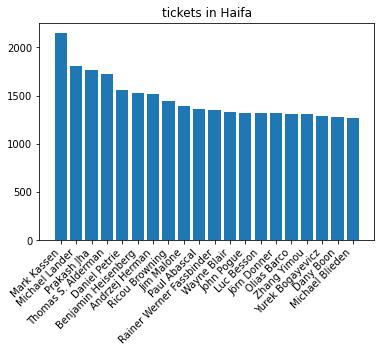

In [ ]:
#insight 2.1 - search by director
for city in ['Haifa']:
  specific_clients = full_tickets.filter(full_tickets.user_location==city)

  q1 =queries

  q1 = q1.select(q1.user_id,q1.director)
  q1 =q1.select("user_id", f.translate(f.col("director"), "[]'", "").alias("director"))

  q1 = q1.select(q1.user_id,f.explode(f.split('director',', ')).alias("director"))


  specific_query = specific_clients.join(q1,specific_clients.user_id==queries.user_id,"inner")

  from pyspark.sql.functions import when

  Tlv_query = Tlv_query.withColumn("director",\
  when(Tlv_query.actors == "","null")\
  .otherwise(Tlv_query.actors))

  search = specific_query.groupBy("director").count().orderBy(col("count").desc())
  
  all = search.limit(20).toPandas()
  all = all.dropna()
  plt.bar(all['director'], all['count'] )
  plt.xticks(rotation = 45 , ha="right")
  plt.title('tickets in '+ city)
  plt.show()

תובנה 2.1
מהגרף עולה כי לא קיימת מגמה מובהקת לבמאי מועדף.
כמות החיפושים עבור הבימאים מתפלגת בצורה שווה  
:עם העדפה קלה עבור הבימאי

mark kassen

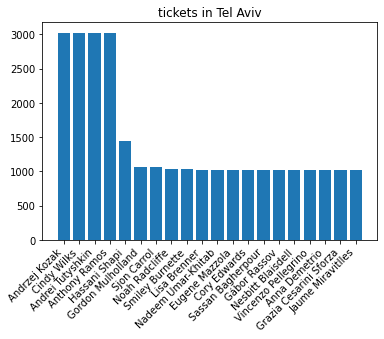

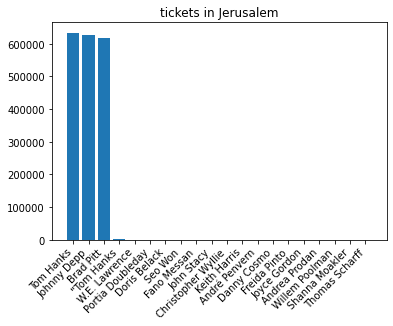

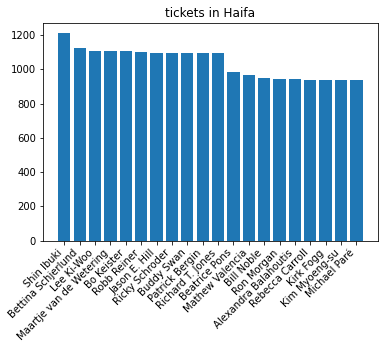

In [ ]:
#insight 2.2 - search by actors
for city in ["Tel Aviv","Jerusalem", 'Haifa']:
  specific_clients = full_tickets.filter(full_tickets.user_location==city)

  q1 =queries

  q1 = q1.select(q1.user_id,q1.actors)
  q1 =q1.select("user_id", f.translate(f.col("actors"), "[]'", "").alias("actors"))

  q1 = q1.select(q1.user_id,f.explode(f.split('actors',', ')).alias("actors"))


  specific_query = specific_clients.join(q1,specific_clients.user_id==queries.user_id,"inner")

  from pyspark.sql.functions import when

  Tlv_query = Tlv_query.withColumn("actors",\
  when(Tlv_query.actors == "","null")\
  .otherwise(Tlv_query.actors))

  search = specific_query.groupBy("actors").count().orderBy(col("count").desc())
  
  all = search.limit(20).toPandas()
  all = all.dropna()
  plt.bar(all['actors'], all['count'] )
  plt.xticks(rotation = 45 , ha="right")
  plt.title('tickets in '+ city)
  plt.show()


תובנה 2.2:
מהגרפים ניתן לראות כי בחיפה ובתל אביב לא קיימת מגמה ברורה עבור שחקנים מועדפים ואילו בירושלים ישנם שלושה שחקנים שהיו הפופולריים ביותר בחיפושים



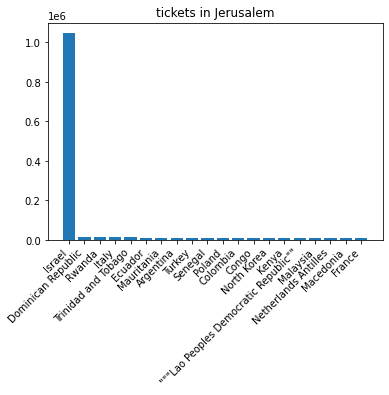

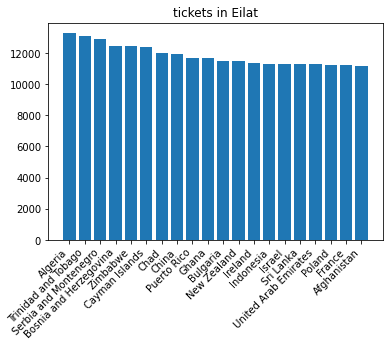

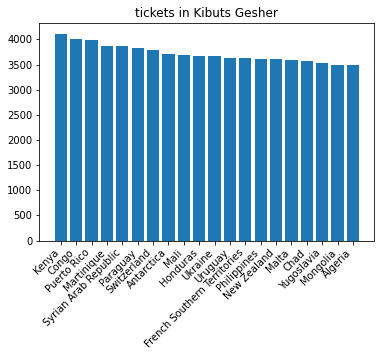

In [ ]:
#insight 2.3 - search by country
for city in ["Jerusalem","Eilat",'Kibuts Gesher']:
  specific_clients = full_tickets.filter(full_tickets.user_location==city)

  q1 =queries

  q1 = q1.select(q1.user_id,q1.country)
  q1 =q1.select("user_id", f.translate(f.col("country"), "[]'", "").alias("country"))

  q1 = q1.select(q1.user_id,f.explode(f.split('country',', ')).alias("country"))


  specific_query = specific_clients.join(q1,specific_clients.user_id==queries.user_id,"inner")

  from pyspark.sql.functions import when

  Tlv_query = Tlv_query.withColumn("country",\
  when(Tlv_query.actors == "","null")\
  .otherwise(Tlv_query.actors))

  search = specific_query.groupBy("country").count().orderBy(col("count").desc())
  
  all = search.limit(20).toPandas()
  all = all.dropna()
  plt.bar(all['country'], all['count'] )
  plt.xticks(rotation = 45 , ha="right")
  plt.title('tickets in '+ city)
  plt.show()


תובנה 2.3
ניתן להסיק מהגרפים כי בחיפה ובקיבות גשר לא קיימת העדפה ברורה עבור מדינות ההפקה של הסרטים
ואילו בירושלים עולה כי ישנה העדפה מובהקת לסרטים אשר הופקו בישראל

In [ ]:
#Third insight 

for city in ["Tel Aviv" ,"Jerusalem", 'Haifa',"Eilat",'Kibuts Gesher']:
  TelAviv_clients = full_tickets.filter(full_tickets.user_location==city)

  queries.select(f.col("from_realese_date"))
  q1 =queries


  q1 = q1.select(q1.user_id,q1.lang)
  q1 =q1.select("user_id", f.translate(f.col("lang"), "[]' ", "").alias("lang"))

  q1 = q1.select(q1.user_id,f.explode(f.split('lang',',')).alias("lang"))

  Tlv_query = TelAviv_clients.join(q1,TelAviv_clients.user_id==queries.user_id,"inner")


  from pyspark.sql.functions import when

  Tlv_query = Tlv_query.withColumn("lang", when((Tlv_query.lang != "English") & (Tlv_query.lang != "עִבְרִית"),"Other")\
  .when(Tlv_query.lang == "עִבְרִית","Hebrew")\
  .otherwise(Tlv_query.lang))


  Tlv_query = Tlv_query.groupBy("user_location","lang").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())

  all = Tlv_query.limit(10).toPandas()
  all = all.dropna()
  plt.bar(all['lang'], all['sum(number_of_tickets)'] )
  plt.title('tickets in '+ city)
  plt.show()

תובנה שלישית: החלטנו לחלק את השפות שלוש קטוגריות - עברית , אנגלית ואחר (כל השפות האחרות)
לאחר ניתוח על טבלת השאליתות ניתן לראות כי בכל הערים הלקוחות חיפשו בעיקר סרטים באנגלית ומעט מאוד סרטים בעברית , מלבד ירושלים שם חיפוש הסרטים בעברית היה גבוהה ופופלרי ביחס לשאר היעדים.

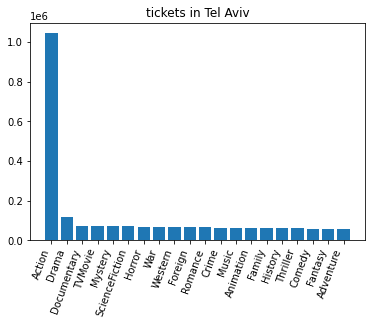

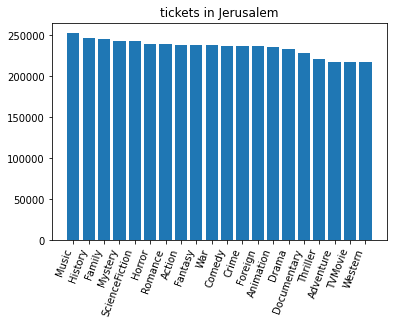

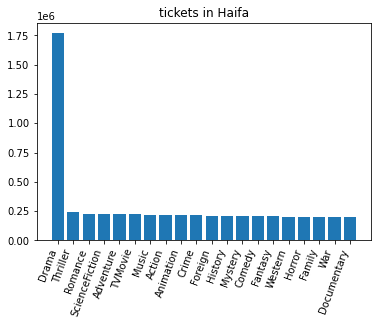

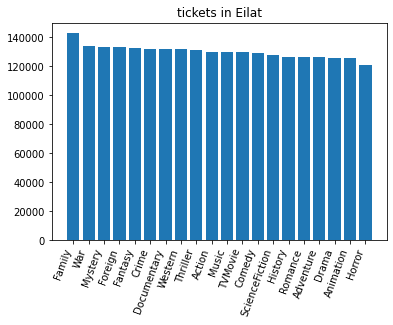

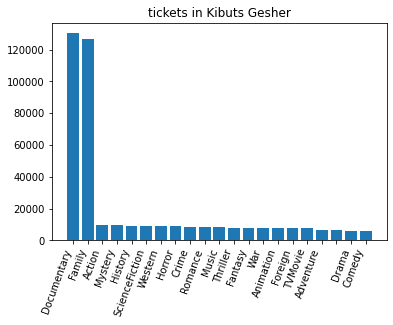

In [ ]:
#Fourth insight


for city in ["Tel Aviv","Jerusalem", 'Haifa',"Eilat",'Kibuts Gesher']:
  TelAviv_clients = full_tickets.filter(full_tickets.user_location==city)

  queries.select(f.col("genres"))
  q1 =queries

  q1 = q1.select(q1.user_id,q1.genres)
  q1 =q1.select("user_id", f.translate(f.col("genres"), "[]' ","").alias("genres"))

  q1 = q1.select(q1.user_id,f.explode(f.split('genres',',')).alias("genres"))


  Tlv_query = TelAviv_clients.join(q1,TelAviv_clients.user_id==queries.user_id,"inner")


  from pyspark.sql.functions import when

  Tlv_query = Tlv_query.groupBy("user_location","genres").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())

  all = Tlv_query.toPandas()
  all = all.dropna()
  plt.bar(all['genres'], all['sum(number_of_tickets)'] )
  plt.xticks(rotation=70, ha="right")
  plt.title('tickets in '+ city)
  plt.show()


תובנה רביעית: מהגרפים עולה כי בתל אביב וחיפה 
קיימת העדפה ברורה לסרטי דרמה
ואילו בקיבוץ גשר ישנה העדפה לסרטי משפחה וסרטים דוקומנטריים.
עבור חיפה ואילת לא קיימת העדפה מובהקת לג'אנר מסוים



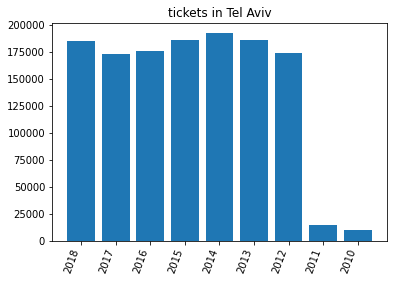

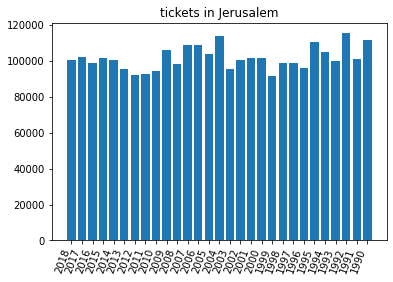

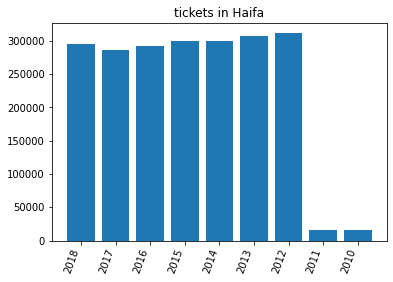

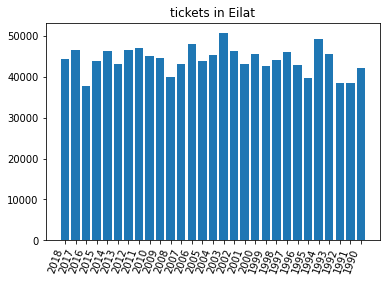

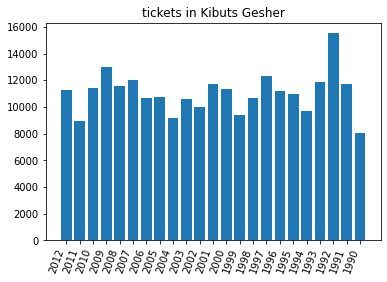

In [ ]:
#Fifth insight
for city in ["Tel Aviv" ,"Jerusalem", 'Haifa',"Eilat",'Kibuts Gesher']:
  TelAviv_clients = full_tickets.filter(full_tickets.user_location==city)

  queries.select(f.col("from_realese_date"))
  q1 =queries


  q1 = q1.select(q1.user_id,q1.from_realese_date)
  q1 =q1.select("user_id", f.translate(f.col("from_realese_date"), "[]' ", "").alias("from_realese_date"))

  q1 = q1.select(q1.user_id,f.explode(f.split('from_realese_date',',')).alias("from_realese_date"))


  Tlv_query = TelAviv_clients.join(q1,TelAviv_clients.user_id==queries.user_id,"inner")


  from pyspark.sql.functions import when
  Tlv_query = Tlv_query.withColumn("from_realese_date", when(f.regexp_extract('from_realese_date', '^\d+$', 0) == '',None)\
  .otherwise(Tlv_query.from_realese_date))
  Tlv_query = Tlv_query.groupBy("user_location","from_realese_date").sum("number_of_tickets").orderBy(col("from_realese_date").desc())

  all = Tlv_query.toPandas()
  all = all.dropna()
  plt.bar(all['from_realese_date'], all['sum(number_of_tickets)'] )
  plt.xticks(rotation=70, ha="right")
  plt.title('tickets in '+ city)
  plt.show()


תובנה חמישית: מהגרפים עולה כי בחיפה ובתל אביב מעדיפים לראות בעיקר סרטים שיצאנו החל משנת 2010 והלאה.
ואילו באילת, ירושלים וקיבוץ גשר , לקוחות התעיינו בסרטים החל משנת 1990 ואילך
 

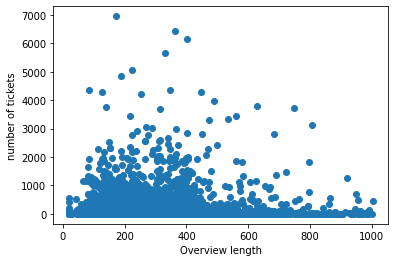

In [ ]:
#Sixth insight
q = full_tickets.groupBy("movie_id").sum("number_of_tickets").orderBy(col("sum(number_of_tickets)").desc())
q = q.withColumnRenamed("movie_id","movie_id1")
partial_movies = full_movies.select('movie_id','Overview_length')
q = q.join(partial_movies, q.movie_id1 ==  partial_movies.movie_id,"inner").orderBy(col("Overview_length").desc())
q = q.drop("movie_id1") 


pdf = q.toPandas()
pdf[['Overview_length1']] = pd.DataFrame(pdf.Overview_length.tolist(), index= pdf.index)
plt.scatter(pdf['Overview_length1'], pdf['sum(number_of_tickets)'] )
plt.xlabel('Overview length')
plt.ylabel('number of tickets')
plt.show()

תובנה שישית:

-ניסנו לבדוק האם קיים קשר בין אורך התיאור

(overview)

לבין כמות קניית הכרטיסים בפועל.
מהגרף לא הצלחנו למצוא קשר מספיק חזק בין אורך התיאור לכמות הכרטיסים הנקנת בפועל.
אמנם ניתן לראות כי עבור תקצירים עד אורך 600 מילים אכן כמות הכרטיסים הנקנת נעה בין 1000 ל3000
ואילו לתיאורים ארוכים מ600 מילים הכמות הנקנת היא פחות 1000.
אך ניתן לקשר זאת לכמות הדגימות שאינה מתפלגת באופן שווה ביחס לאורך התיאור, דבר אשר עלול ליצור הטייה. בנוסף קיימת שונות מאוד גבוהה ולכן לא ניתן להסיק תובנה חד משמעית

PART 4

In [ ]:
%%file part4.py

def make_df_sites(path=""):
  import findspark
  findspark.init()
  from pyspark.sql import SparkSession

  import part1

  def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

  spark, sc = init_spark('demo')

  full_movies, full_tickets, queries = part1.get_all_df()

  return get_full_movies_df_sites(full_movies,path)+get_full_tickets_df_sites(full_tickets,path)


def get_full_movies_df_sites(full_movies,path):

  import re
  from pyspark.sql import functions as f
  from pyspark.sql import types as T
  #from pyspark.sql import functions as F
  import pandas as pd
  import matplotlib.pyplot as plt
  from pyspark.sql.functions import col,when

  full_movies = full_movies.drop("Overview_length")


  # fragmentation: for full_movies

  # full movies fractioning:------------------------------------------------------------------------------------------------------
  #for TLV site:
  TLV_movies = full_movies.drop("crew","production_countries")

  TLV_movies = TLV_movies.withColumn('genres', f.explode(TLV_movies['genres']))
  TLV_movies = TLV_movies.filter(TLV_movies.genres == "Action")


  TLV_movies = TLV_movies.withColumn('spoken_languages', f.explode(TLV_movies['spoken_languages']))
  TLV_movies = TLV_movies.filter(TLV_movies.spoken_languages != "Hebrew")

  TLV_movies = TLV_movies.withColumn('release_date', f.explode(TLV_movies['release_date']))
  TLV_movies = TLV_movies.filter(TLV_movies.release_date >= 2010)

  TLV_movies = TLV_movies.groupBy("movie_id")\
  .agg(f.collect_set("release_date").alias("release_date1")\
  ,f.collect_set("spoken_languages").alias("spoken_languages1")
  ).alias("movie_id1")
  TLV_movies = TLV_movies.join(full_movies,["movie_id"] ,"inner")
  TLV_movies = TLV_movies.drop("release_date1","spoken_languages1","crew","production_countries")


  # full movies fractioning:------------------------------------------------------------------------------------------------------
  #for Haifa site:
  Haifa_movies = full_movies.drop("production_countries")

  Haifa_movies = Haifa_movies.withColumn('genres', f.explode(Haifa_movies['genres']))
  Haifa_movies = Haifa_movies.filter(Haifa_movies.genres == "Drama")


  Haifa_movies = Haifa_movies.withColumn('spoken_languages', f.explode(Haifa_movies['spoken_languages']))
  Haifa_movies = Haifa_movies.filter(Haifa_movies.spoken_languages != "Hebrew")

  Haifa_movies = Haifa_movies.withColumn('release_date', f.explode(Haifa_movies['release_date']))
  Haifa_movies = Haifa_movies.filter(Haifa_movies.release_date >= 2010)

  #unexplodes the movies dataframe
  Haifa_movies = Haifa_movies.groupBy("movie_id")\
  .agg(f.collect_set("release_date").alias("release_date1")\
  ,f.collect_set("spoken_languages").alias("spoken_languages1")
  )

  Haifa_movies = Haifa_movies.join(full_movies,["movie_id"] ,"inner")
  Haifa_movies = Haifa_movies.drop("release_date1","spoken_languages1","production_countries")




  # full movies fractioning:------------------------------------------------------------------------------------------------------
  #for Jerusalem site:
  Jerusalem_movies = full_movies.drop("crew")


  Jerusalem_movies = Jerusalem_movies.withColumn('spoken_languages', f.explode(Jerusalem_movies['spoken_languages']))
  Jerusalem_movies = Jerusalem_movies.filter(Jerusalem_movies.spoken_languages != "Other")


  # unexplodes the movies dataframe
  Jerusalem_movies = Jerusalem_movies.groupBy("movie_id")\
  .agg(f.collect_set("spoken_languages").alias("spoken_languages1")
  )

  Jerusalem_movies = Jerusalem_movies.join(full_movies,["movie_id"] ,"inner")
  Jerusalem_movies = Jerusalem_movies.drop("spoken_languages1","crew")

  # Jerusalem_movies.show(truncate=False)

  # Jerusalem_movies.show()
  Jerusalem_movies = Jerusalem_movies.withColumn('production_countries', f.explode(Jerusalem_movies['production_countries']))
  Jerusalem_movies = Jerusalem_movies.filter(Jerusalem_movies.production_countries == "Israel")


  # unexplodes the movies dataframe
  Jerusalem_movies = Jerusalem_movies.groupBy("movie_id")\
  .agg(f.collect_set("production_countries").alias("production_countries1")
  )

  Jerusalem_movies = Jerusalem_movies.join(full_movies,["movie_id"] ,"inner")
  Jerusalem_movies = Jerusalem_movies.drop("production_countries1","crew")

  # full movies fractioning:------------------------------------------------------------------------------------------------------
  #for TLV site:
  Tiberias_movies = full_movies.drop("production_countries")

  Tiberias_movies = Tiberias_movies.withColumn('genres', f.explode(Tiberias_movies['genres']))
  Tiberias_movies = Tiberias_movies.filter((Tiberias_movies.genres == "Documentary") | (Tiberias_movies.genres == "Family"))


  Tiberias_movies = Tiberias_movies.withColumn('spoken_languages', f.explode(Tiberias_movies['spoken_languages']))
  Tiberias_movies = Tiberias_movies.filter(Tiberias_movies.spoken_languages != "Hebrew")



  #unexplodes the movies dataframe
  Tiberias_movies = Tiberias_movies.groupBy("movie_id")\
  .agg(f.collect_set("spoken_languages").alias("spoken_languages1")
  ,f.collect_set("genres").alias("genres1")
  )

  Tiberias_movies = Tiberias_movies.join(full_movies,["movie_id"] ,"inner")
  Tiberias_movies = Tiberias_movies.drop("genres1","spoken_languages1","production_countries")


  # makes Eilat_movies##########################################################################
  TLV = TLV_movies.select(TLV_movies.movie_id)
  Haifa = Haifa_movies.select(Haifa_movies.movie_id)
  Jerusalem = Jerusalem_movies.select(Jerusalem_movies.movie_id)
  Tiberias = Tiberias_movies.select(Tiberias_movies.movie_id)

  df = TLV.join(Haifa,["movie_id"] ,"outer")
  df = df.join(Jerusalem,["movie_id"] ,"outer")
  df = df.join(Tiberias,["movie_id"] ,"outer")

  Eilat_movies = full_movies.join(df,["movie_id"] ,"leftanti")

  from pyspark.sql.functions import col

  TLV_movies = TLV_movies.select([col(c).cast("string") for c in TLV_movies.columns])
  TLV_movies=TLV_movies.repartition(1)
  TLV_movies.write.option("header", True).mode('append').csv(path +"/Tel_Aviv_Site/Tel_Aviv_movies_site")

  Haifa_movies = Haifa_movies.select([col(c).cast("string") for c in Haifa_movies.columns])
  Haifa_movies=Haifa_movies.repartition(1)
  Haifa_movies.write.option("header", True).mode('append').csv(path +"/Haifa_Site/Haifa_movies_site")

  Jerusalem_movies = Jerusalem_movies.select([col(c).cast("string") for c in Jerusalem_movies.columns])
  Jerusalem_movies=Jerusalem_movies.repartition(1)
  Jerusalem_movies.write.option("header", True).mode('append').csv(path + "/Jerusalem_Site/Jerusalem_movies_site")

  Tiberias_movies = Tiberias_movies.select([col(c).cast("string") for c in Tiberias_movies.columns])
  Tiberias_movies=Tiberias_movies.repartition(1)
  Tiberias_movies.write.option("header", True).mode('append').csv(path + "/Tiberias_Site/Tiberias_movies_site")

  Eilat_movies = Eilat_movies.select([col(c).cast("string") for c in Eilat_movies.columns])
  Eilat_movies=Eilat_movies.repartition(1)
  Eilat_movies.write.option("header", True).mode('append').csv(path + "/Eilat_Site/Eilat_movies_site")






  return TLV_movies,Haifa_movies,Jerusalem_movies,Tiberias_movies,Eilat_movies


def get_full_tickets_df_sites(full_tickets,path):

  import re
  from pyspark.sql import functions as f
  from pyspark.sql import types as T
  #from pyspark.sql import functions as F
  import pandas as pd
  import matplotlib.pyplot as plt
  from pyspark.sql.functions import col,when

  # fragmentation: for full_tickets

  # full tickets fractioning:------------------------------------------------------------------------------------------------------

  TLV_tickets = full_tickets.filter(full_tickets.city == "Tel Aviv")

  Haifa_tickets = full_tickets.filter(full_tickets.city == "Haifa")

  Jerusalem_tickets = full_tickets.filter(full_tickets.city == "Jerusalem")

  Tiberias_tickets = full_tickets.filter(full_tickets.city == "Tiberias")

  Tiberias_tickets = full_tickets.filter(full_tickets.city == "Tiberias")

  Eilat_tickets = full_tickets.filter(full_tickets.city == "Eilat")



  from pyspark.sql.functions import col

  TLV_tickets = TLV_tickets.select([col(c).cast("string") for c in TLV_tickets.columns])
  TLV_tickets=TLV_tickets.repartition(1)
  TLV_tickets.write.option("header", True).mode('append').csv(path +"/Tel_Aviv_Site/Tel_Aviv_tickets_site")

  Haifa_tickets = Haifa_tickets.select([col(c).cast("string") for c in Haifa_tickets.columns])
  Haifa_tickets=Haifa_tickets.repartition(1)
  Haifa_tickets.write.option("header", True).mode('append').csv(path +"/Haifa_Site/Haifa_tickets_site")

  Jerusalem_tickets = Jerusalem_tickets.select([col(c).cast("string") for c in Jerusalem_tickets.columns])
  Jerusalem_tickets=Jerusalem_tickets.repartition(1)
  Jerusalem_tickets.write.option("header", True).mode('append').csv(path + "/Jerusalem_Site/Jerusalem_tickets_site")

  Tiberias_tickets = Tiberias_tickets.select([col(c).cast("string") for c in Tiberias_tickets.columns])
  Tiberias_tickets=Tiberias_tickets.repartition(1)
  Tiberias_tickets.write.option("header", True).mode('append').csv(path + "/Tiberias_Site/Tiberias_tickets_site")

  Eilat_tickets = Eilat_tickets.select([col(c).cast("string") for c in Eilat_tickets.columns])
  Eilat_tickets=Eilat_tickets.repartition(1)
  Eilat_tickets.write.option("header", True).mode('append').csv(path + "/Eilat_Site/Eilat_tickets_site")


  return TLV_tickets,Haifa_tickets,Jerusalem_tickets,Tiberias_tickets,Eilat_tickets


Overwriting part4.py


In [ ]:
from importlib import reload
import part4 

reload(part4)
TLV_movies,Haifa_movies,Jerusalem_movies,Tiberias_movies,Eilat_movies,TLV_tickets,Haifa_tickets,Jerusalem_tickets,Tiberias_tickets,Eilat_tickets = part4.make_df_sites("/content")


+--------+-------------------------+--------------------------------------------------------------------------------------------------------------+--------------------------+------------+---------+----------------+-------------------------------------+---------------------------------------------+---------------+----+----+
|movie_id|genres                   |production_companies                                                                                          |production_countries      |release_date|revenue  |spoken_languages|title                                |cities                                       |Overview_length|cast|crew|
+--------+-------------------------+--------------------------------------------------------------------------------------------------------------+--------------------------+------------+---------+----------------+-------------------------------------+---------------------------------------------+---------------+----+----+
|100     |[Comedy, Crime]

(DataFrame[movie_id: string, genres: array<string>, production_companies: array<string>, release_date: array<int>, revenue: array<string>, spoken_languages: array<string>, title: array<string>, cities: array<string>, Overview_length: array<int>, cast: array<struct<order:int,id:int,name:string,gender:int>>],
 DataFrame[movie_id: string, genres: array<string>, production_companies: array<string>, release_date: array<int>, revenue: array<string>, spoken_languages: array<string>, title: array<string>, cities: array<string>, Overview_length: array<int>, cast: array<struct<order:int,id:int,name:string,gender:int>>, crew: array<struct<id:int,name:string,job:string,gender:int>>],
 DataFrame[movie_id: string, genres: array<string>, production_companies: array<string>, production_countries: array<string>, release_date: array<int>, revenue: array<string>, spoken_languages: array<string>, title: array<string>, cities: array<string>, Overview_length: array<int>, cast: array<struct<order:int,id:int,